## SME: BJ goods and competitive banks 
Given policy $\tau$, we get real money balance $(z)$ and market interest rate $(i=i_{l}=i_{d})$ by solving

\begin{equation}
\begin{split}
z^{\star} \leftarrow  \frac{1+\tau -\beta}{\beta} &= R(z,i)
\\
i_{l}=i_{d}=i^{\star} \leftarrow (1-n) \cdot z + n \cdot \int^{\overline{\rho}}_{\hat{\rho}} [\alpha_{1}+2\alpha_{2}(1-J(\rho))] \delta(i,\rho,z)\text{d}J(\rho)&= n \cdot \int^{\tilde{\rho}}_{\underline{\rho}} [\alpha_{1}+2\alpha_{2}(1-J(\rho))] \xi(i,\rho,z) \text{d}J(\rho)
\end{split}
\label{eq:k-phi-high-type-case1}
\end{equation}

where
\begin{equation*}
\begin{split}
R(z,i) &:=  \color{blue}{(1-n)} \cdot i + \color{blue}{n}\bigg[\int^{\tilde{\rho}}_{\underline{\rho}} i [\alpha_{1}+2\alpha_{2}(1-J(\rho))] \text{d}J(\rho)
\\
&+ \int^{\hat{\rho}}_{\tilde{\rho}} [\alpha_{1}+2\alpha_{2}(1-J(\rho))] \bigg[\frac{1}{\rho}\bigg(\frac{z}{\rho}\bigg)^{-\sigma} -1 \bigg] \text{d}J(\rho)
\\
&+ \int^{\overline{\rho}}_{\hat{\rho}} [\alpha_{1}+2\alpha_{2}(1-J(\rho))] \cdot i \text{d}J(\rho)\bigg]
\end{split}
\end{equation*}

#### This Jupyter notebook reports the equilibrium outcomes in the SME.

- First, it provides detailed calculations of the CEV (Consumption Equivalent Variation).
- Additionally, it examines how real balances($z$), interest rates($i$), markup($\mu$), and markup dispersion($CV_{\mu}$) change with inflation.

- The main figure, Figure 4. 'Consumption Equivalent Variation (%)' of transitioning from the no-bank HLMW economy to the baseline economy with banking." 
- Also, include Figure 12. 'The effects of inflation on the aggregate markup and price dispersion'

In [1]:
import bcw_bj as main
import hlmw as hlmw
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import interpolate
from scipy.optimize import brentq, fsolve
#import tikzplotlib
import time

In [2]:
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'

In [3]:
font = {'family' : 'serif','weight':'normal',
        'size'   : 10}
plt.rc('font', **font)

In [4]:
σ_DM=0.3200
Ubar_CM=1.8000
n=0.65
α_1=0.0475
β=0.981
τ_min=β-1
τ_max = 0.05
τgrid_size = 60

In [5]:
model = main.baseline_mod(β=β,σ_DM=σ_DM, Ubar_CM=Ubar_CM, n=n,τ_max = τ_max,α_1=α_1,τgrid_size = τgrid_size,τ_min=τ_min)

model_hlmw =hlmw.hlmw_mod(β=β,σ_DM=σ_DM, Ubar_CM=Ubar_CM, n=n,τ_max = τ_max,α_1=α_1,τgrid_size = τgrid_size,τ_min=τ_min)

### SME: HLMW + perfectly competitive banks (Baseline)

* Vary $\tau \in [\beta-1, 0.1]$

In [6]:
z_guess = 0.7
i_guess = 0.01
result = model.SME_stat(z_guess, i_guess) # this uses fsolve

Elapsed time of solving SME: 103.91915488243103 seconds


In [7]:
z = result['allocation_grid']['zstar']
q = result['allocation_grid']['qstar']
ξ = result['allocation_grid']['ξstar']
i = result['allocation_grid']['istar']
DM_surplus = result['allocation_grid']['DM_surplus']
W = result['allocation_grid']['w_star']
W_BCW = result['allocation_grid']['w_bcw']

mpy = result['stat_grid']['mpy_star']
markup = result['stat_grid']['markup_mean']
markup_cv = result['stat_grid']['markup_cv']
loan_gdp = result['stat_grid']['credit_gdp']
loan_gdp_bcw = result['stat_grid']['credit_gdp_bcw']

### HLMW: without banks

In [8]:
result_hlmw = model_hlmw.SME_stat() # this uses brentq only

Elapsed time of solving SME: 67.63270473480225 seconds


In [9]:
z_hlmw = result_hlmw['allocation_grid']['zstar']
q_hlmw = result_hlmw['allocation_grid']['qstar']
W_hlmw = result_hlmw['allocation_grid']['w_star']
DM_surplus_hlmw = result_hlmw['allocation_grid']['DM_surplus']

mpy_hlmw = result_hlmw['stat_grid']['mpy_star']
markup_hlmw = result_hlmw['stat_grid']['markup_mean']
markup_cv_hlmw = result_hlmw['stat_grid']['markup_cv']

In [10]:
τ_grid = model.τ_grid # inflation rate grid
i_grid = model.i_policy(τ_grid)

In [11]:
def gap_percent_func(delta_W_bank, W_no_bank):
    """Use this function to calculate CEV"""
    n_point = 60
    delta = np.append(np.linspace(2, 1, round(n_point/2), endpoint=False), (np.linspace(1, 0.1, round(n_point/2))))
    gap_welfare = delta_W_bank - W_no_bank
    interp_fn = interpolate.interp1d(delta, gap_welfare, 'cubic')
    interp_fn2 = lambda x: interp_fn(x) - 0.0
    gap_delta = brentq(interp_fn2, delta.min(), delta.max())
    cev = (1.0 - gap_delta) * 100
    return cev

In [12]:
def calculate_cev_percent(τ, z_guess, i_guess, case='Case1'):
    n_point = 60
    delta = np.append(np.linspace(2, 1, round(n_point/2), endpoint=False), (np.linspace(1, 0.1, round(n_point/2))))

    # klln
    z, i = model.solve_z_i(z_guess, i_guess, τ)

    # hlmw
    z_hlmw = model_hlmw.z_solver(τ)
    
    # Welfare increases by delta
    if case == 'Case1':
        delta_klln = [model.welfare_func_delta(z, i, τ, k) for k in delta]
            
    elif case == 'Case2':
        delta_bcw = [model.welfare_bcw_func_delta(τ, k) for k in delta]
            
    elif case == 'Case3':
        delta_bcw = [model.welfare_bcw_func_delta(τ, k) for k in delta]

    ### HLMW
    welfare_hlmw = model_hlmw.welfare_func(z_hlmw, τ)
    
    ### Baseline
    welfare_klln = model.welfare_func(z, i, τ)
    
    ### BCW
    welfare_bcw = model.welfare_bcw_func(τ)
    
    if case == 'Case1':
        cev_percent = gap_percent_func(delta_klln, welfare_hlmw)
        
    elif case == 'Case2':
        cev_percent = gap_percent_func(delta_bcw, welfare_klln)
        
    elif case == 'Case3':
        cev_percent = gap_percent_func(delta_bcw, welfare_hlmw)
  

    return cev_percent


In [13]:
Case1_cev = [calculate_cev_percent(j, z_guess, i_guess, case='Case1') for j in τ_grid ]

## Figure 4: Consumption Equivalent Variation (%) of moving from the no-bank HLMW economy to the baseline economy with banking.

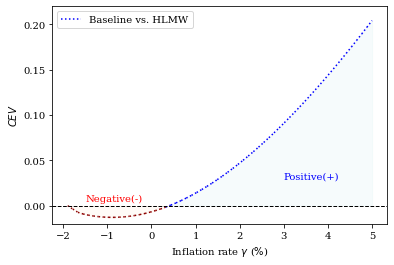

In [14]:
##### ZOOM-IN

##### plt.style.use(style='default')
plt.figure(facecolor='white')
# Initialize a flag to indicate when the label has been added
label_added_red = False
label_added_blue = False

for i in range(1, len(i_grid[0:60])):
    if Case1_cev[i-1] <= 0 and Case1_cev[i] > 0 or Case1_cev[i-1] > 0 and Case1_cev[i] > 0:
        # This segment is positive, plot in blue
        if not label_added_blue:
            plt.plot(model.τ_grid[i-1:i+1]*100, Case1_cev[i-1:i+1], color='blue', linestyle=':', label='Baseline vs. HLMW')
            label_added_blue = True
        else:
            plt.plot(model.τ_grid[i-1:i+1]*100, Case1_cev[i-1:i+1], color='blue', linestyle=':')
    else:
        # This segment is not positive, plot in dark red
        if not label_added_red:
            plt.plot(model.τ_grid[i-1:i+1]*100, Case1_cev[i-1:i+1], color='darkred', linestyle=':')
            label_added_red = True
        else:
            plt.plot(model.τ_grid[i-1:i+1]*100, Case1_cev[i-1:i+1], color='darkred', linestyle=':')


#plt.plot(i_grid[0:10]*100, np.zeros(τ_grid[0:30].size))
plt.ylabel("$CEV$")
plt.xlabel(r'Inflation rate $\gamma$ ($\%$)')
plt.legend()
plt.axhline(y=0,color="black", linestyle='--',linewidth=1.0)
plt.fill_between(model.τ_grid[0:]*100, Case1_cev[0:], where=(np.array(Case1_cev)[0:] <= 0), color='peachpuff', alpha=0.1, interpolate=True)
plt.fill_between(model.τ_grid[0:]*100, Case1_cev[0:], where=(np.array(Case1_cev)[0:] >= 0), color='#B0E0E6', alpha=0.1, interpolate=True)
plt.text(-1.5, 0.005, 'Negative(-)',size=10,color='red')
plt.text(3, 0.03, 'Positive(+)',size=10,color='blue')
plt.ylim(-0.02,0.22)
plt.savefig("cev_zoom_in.png", bbox_inches='tight', pad_inches=0.05)
plt.show()

## Figure 12: The effects of inflation on the aggregate markup and price dispersion

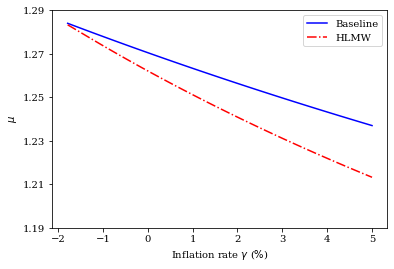

In [15]:
plt.figure(facecolor='white')
plt.plot(100*(model.τ_grid[1:]), markup[1:], color='blue', label='Baseline') #exclude FR
plt.plot(100*(model.τ_grid[1:]), markup_hlmw[1:], '-.', color='red', label='HLMW') #exclude FR
plt.ylabel(r'$μ$')
plt.xlabel(r'Inflation rate $\gamma$ ($\%$)')
plt.legend()
plt.yticks(np.arange(1.19,1.3, 0.02))
#plt.xlim(-0.5,8)
plt.savefig("markup.png", bbox_inches='tight', pad_inches=0.05)
plt.show()


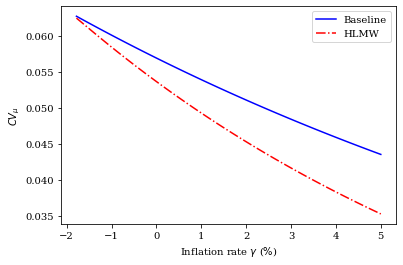

In [16]:
plt.figure(facecolor='white')
plt.plot(100*(model.τ_grid[1:]), markup_cv[1:], color='blue', label='Baseline') #exclude FR
plt.plot(100*(model.τ_grid[1:]), markup_cv_hlmw[1:], '-.', color='red', label='HLMW') #exclude FR
plt.ylabel(r'$CV_{μ}$')
plt.xlabel(r'Inflation rate $\gamma$ ($\%$)')
plt.legend()
#plt.xlim(-0.5,8)
plt.savefig("markup_cv.png", bbox_inches='tight', pad_inches=0.05)
plt.show()

## Additional Figure: Real balance($z$) in Baseline and HLMW economy

- The figure below illustrates the trend of real balances in the steady state of the baseline model and the HLMW economy as inflation($\gamma$) varies.

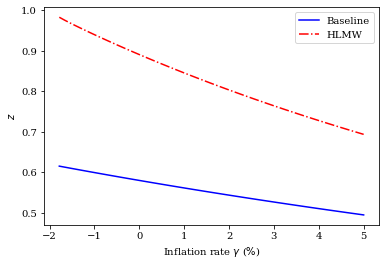

In [17]:
plt.figure(facecolor='white')
plt.plot(100*(model.τ_grid[1:]), z[1:], color='blue', label='Baseline') #exclude FR
plt.plot(100*(model.τ_grid[1:]), z_hlmw[1:], '-.', color='red', label='HLMW') #exclude FR
plt.ylabel(r'$z$')
plt.xlabel(r'Inflation rate $\gamma$ ($\%$)')
plt.legend()
#plt.yticks(np.arange(1.19,1.3, 0.02))
#plt.xlim(-0.5,8)
plt.savefig("z.png", bbox_inches='tight', pad_inches=0.05)
plt.show()

## Additional Figure: interest rate($i$) in Baseline

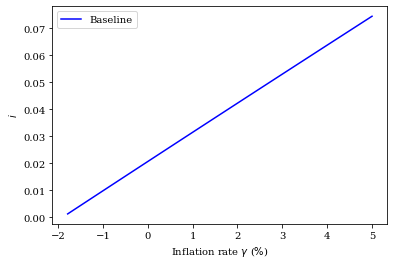

In [18]:
i = result['allocation_grid']['istar']
plt.figure(facecolor='white')
plt.plot(100*(model.τ_grid[1:]), i[1:], color='blue', label='Baseline') #exclude FR
plt.ylabel(r'$i$')
plt.xlabel(r'Inflation rate $\gamma$ ($\%$)')
plt.legend()
#plt.yticks(np.arange(1.19,1.3, 0.02))
#plt.xlim(-0.5,8)
plt.savefig("z.png", bbox_inches='tight', pad_inches=0.05)
plt.show()

## Figure 11: Inflation, individual expenditures, equilibrium pricing distribution and cutoffs: (b) Cutoffs (price ranges) and buyer types

In [29]:
# Our baseline economy
z_grid=result['allocation_grid']['zstar']
z_grid_hlmw=result_hlmw['allocation_grid']['zstar']
# lower bound on prices - money unconstrained buyers
# upper bound on prices - money constrained buyers
ρ_hat_baseline = [model.ρ_hat_func(z) for z in z_grid]

# lower bound - money constrained buyers
# upper bound - credit buyers
ρ_tilde_baseline = [model.ρ_tilde_func(z,i) for (z,i) in zip(z_grid, result['allocation_grid']['istar'])]

# HMLW economy
# lower bound on prices - money unconstrained buyers
# upper bound on prices - money constrained buyers
ρ_hat_hlmw = [model_hlmw.ρ_hat_func(z) for z in z_grid_hlmw]

In [30]:
# Same as model.τ_grid above, just repetition for the heck of it!
if_grid = model.i_policy(model.τ_grid)

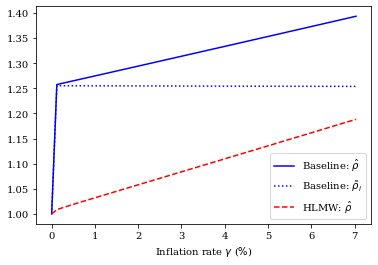

In [31]:
plt.plot(if_grid*100, ρ_hat_baseline, 'b-', label='Baseline: $\hat{ρ}$')
plt.plot(if_grid*100, ρ_tilde_baseline, 'b:', label=r'Baseline: $\tilde{ρ}_{i}$')
plt.plot(if_grid*100, ρ_hat_hlmw, '--', color="red", label='HLMW: $\hat{ρ}$')
plt.xlabel(r'Inflation rate $\gamma$ ($\%$)')
plt.legend()
#plt.xlim(-0.5,8)
plt.savefig("cutoffs.png", dpi=600, bbox_inches='tight', pad_inches=0.05)
plt.show()

## Figure 11: Inflation, individual expenditures, equilibrium pricing distribution and cutoffs: (c) Pricing distribution

In [32]:
z_guess = 0.5
i_guess = 0.01
τ = 0.0

tic = time.time()
z, i = model.solve_z_i(z_guess, i_guess, τ) # system of two equations given zero inflation
toc = time.time() - tic
print(z, i, toc)

0.5792687218214781 0.020640012434918784 0.40065884590148926


In [33]:
τ_1 = 0.1

tic = time.time()
z_1, i_1 = model.solve_z_i(z_guess, i_guess, τ_1) 
toc = time.time() - tic
print(z_1, i_1, toc)

0.42434768699757447 0.1278114562928575 0.5703577995300293


In [34]:
ρ_grid = np.linspace(model.ρ_min_func(z, i, τ), model.ρ_max_func(z,i), 500)
ρ_grid1 = np.linspace(model.ρ_min_func(z_1, i_1, τ_1), model.ρ_max_func(z_1,i_1), 500)
F = model.F_func(i, z,τ)
F1 = model.F_func(i_1, z_1,τ_1)

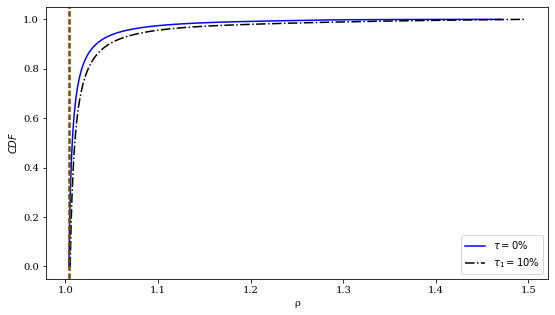

In [35]:
#plt.style.use(style='default')
plt.figure(facecolor='white', figsize=(9,5))
plt.plot(ρ_grid, F, color='blue', label=r"$\tau=0\%$")
plt.axvline(model.ρ_min_func(z, i, τ), linestyle='--', color='red')
plt.plot(ρ_grid1, F1, '-.', color='black', label=r"$\tau_{1}=10\%$")
plt.axvline(model.ρ_min_func(z_1, i_1, τ_1), linestyle='--', color='green')
plt.ylabel("$CDF$")
plt.xlabel("ρ")
plt.legend()
plt.savefig("cdf.png", bbox_inches='tight', pad_inches=0.05)
plt.show()

## Figure 11: Inflation, individual expenditures, equilibrium pricing distribution and cutoffs: (a) Individual expenditures

In [36]:
ρq = [model.q_expenditure(ρ, i, z) for ρ in ρ_grid]
ρq1 = [model.q_expenditure(ρ, i_1, z_1) for ρ in ρ_grid1]

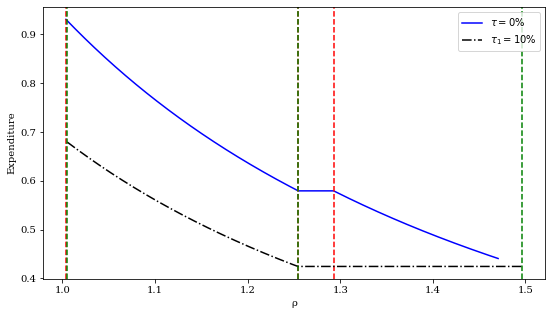

In [37]:
plt.figure(facecolor='white', figsize=(9,5))
plt.plot(ρ_grid, ρq, color='blue', label=r"$\tau=0\%$")
plt.axvline(model.ρ_min_func(z, i, τ), linestyle='--', color='red')
plt.axvline(model.ρ_tilde_func(z, i), linestyle='--', color='red')
#plt.text(1.12, 0.6, r"$\tilde{\rho}_{i}(\tau)$",color='red')
plt.axvline(model.ρ_hat_func(z), linestyle='--', color='red')
#plt.text(1.185, 0.6, r"$\hat{\rho}(\tau)$",color='red')
### inflation at 5%
plt.plot(ρ_grid1, ρq1, '-.', color='black', label=r"$\tau_{1}=10\%$")
plt.axvline(model.ρ_min_func(z_1, i_1, τ_1), linestyle='--', color='green')
plt.axvline(model.ρ_tilde_func(z_1, i_1), linestyle='--', color='green')
#plt.text(1.15, 0.45, r"$\tilde{\rho}_{i}(\tau_{1})$",color='green')
plt.axvline(model.ρ_hat_func(z_1), linestyle='--', color='green')
#plt.text(1.31, 0.45, r"$\hat{\rho}(\tau_{1})$",color='green')
plt.ylabel('Expenditure')
plt.xlabel('ρ')
plt.legend()
plt.savefig("dm_expenditure.png", bbox_inches='tight', pad_inches=0.05)
plt.show()